---
# Part A: Core Task — Implement One Momentum Strategy
---




---
## Assumptions and rules
---

Use a simple, consistent backtest setup:
- Trade at **next day close** (i.e., use yesterday’s signal as today’s position)
- Transaction costs is 0.05% 
- Trading on portfolio of $1 million
- Ignore slippage 
- Long/cash only 
- Start trading start of 2015 to end of 2025


---
## Step 1: Libraries 
---

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs

---
## Step 2: Load price data
---


In [3]:
# Prepare Apple data into a dataframe
def download_stock_data(ticker, start_date):
    data = yf.download(
        ticker,
        start=start_date,
        auto_adjust=True, #prices adjusted for dividends and splits
        progress=False
    )
    return data['Close'] 

# Download Apple data
prices = download_stock_data("AAPL", "2015-01-01") #close prices series indexed by date


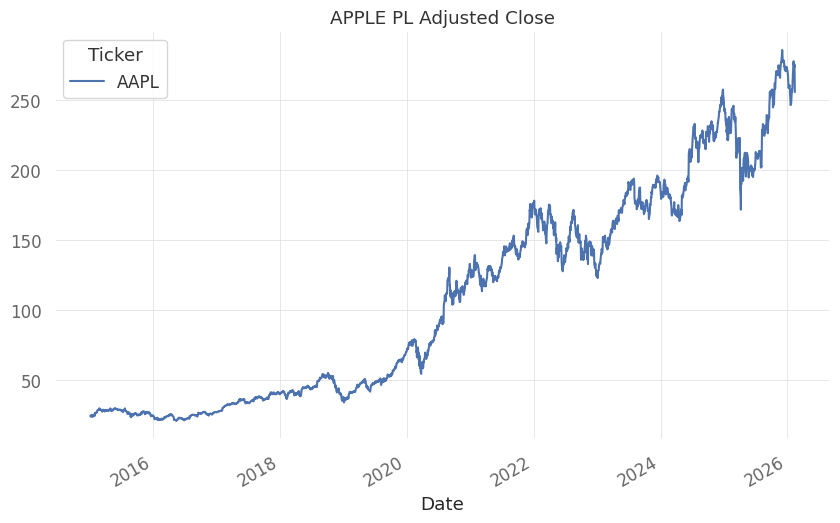

In [4]:
# Display the visualisation of the data
prices.plot(title="APPLE PL Adjusted Close")
plt.show()

---
## Step 2: Karthik - Backtest framework
---

You will generate a `signal`:
- `1` = long
- `0` = cash

The backtest uses `position = signal.shift(1)` to avoid look-ahead bias.


In [ ]:
# Define the function which will develop

---
## Step 3: Implement 3 Strategies
---




---
### Arin: ROC Threshold
---

**Rule:** Buy if the price increased by more than a threshold over the last `roc_n` days.


In [ ]:
# Develop the ROC indicator

---
### Adrian: Moving Average Crossover
---

**Rule:** Buy when a fast moving average is above a slow moving average.


In [ ]:
# Develop the Moving Average Crossover indicator

---
### Piraveen: MACD Signal
---

**Rule:** Buy when MACD is above its signal line.
- `MACD = EMA(12) - EMA(26)`
- `Signal line = EMA(9) of MACD`

**Why MACD beats ROC**

- **ROC**

 - Pure percent change over a fixed lookback

 - Very noisy

 - Sensitive to single jumps

 - No smoothing or regime context

**MACD advantage**

 - Uses EMAs → smooths noise

 - Compares short vs long trend simultaneously

 - Detects acceleration and deceleration, not just movement

**Intuition:**
ROC says “price moved”
MACD says “trend is speeding up or slowing down”

**Why MACD beats MA crossover**

**MA crossover**

 - Binary and laggy

 - Signals only after trend is established

 - Late entries and late exits

**MACD advantage**

 - Signals earlier because it is a difference of EMAs

 - Histogram shows momentum weakening before crossover

 - More information than just cross or no cross

**Intuition:**
MA crossover sees direction
MACD sees change in direction

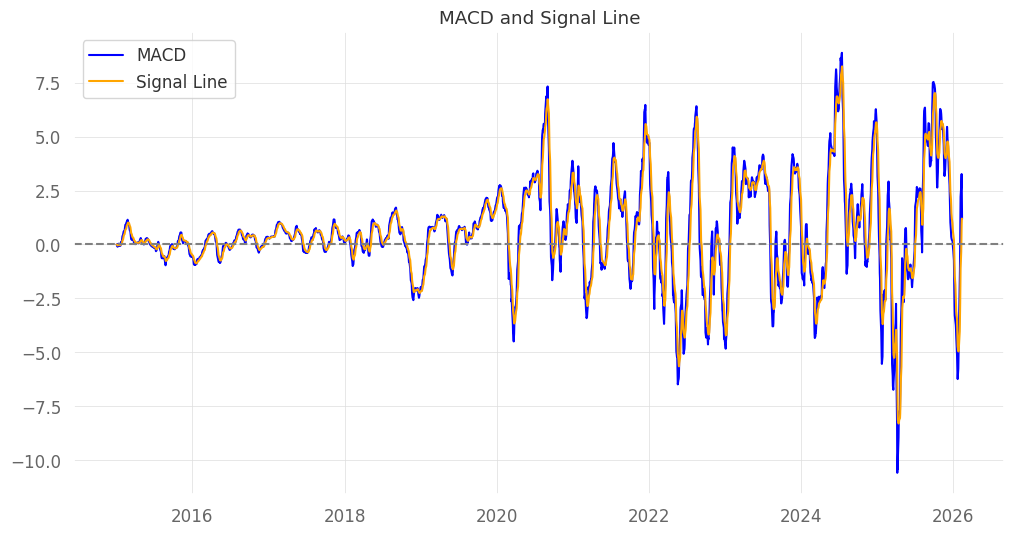

Number of bullish crossovers: Ticker
AAPL    100
dtype: int64
Number of bearish crossovers: Ticker
AAPL    101
dtype: int64


In [10]:
# Compute MACD 
# An exponentially weighed window/ EMA is a way of averaging where recent data matters more than old data and the importance of past observations decays exponentially over time.
# span argument in ewm function shows how dast old data decays.
# adjust=False means that we are calculating the exponentially weighted moving average without adjusting for bias, 
# which is common in financial time series analysis to give more weight to recent data points --> recursive.
# adjust=True reweights the data, artificially boosting the importance of older data points because we divide by sum of historical exp weights--> normalised .

#Compute MACD 

def calculate_macd(prices, fast_span=12, slow_span=26, signal_span=9):
    # Calculate MACD components
    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd_line = ema_fast - ema_slow

    # Smooth the MACD line to get the signal line and calculate the histogram
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    histogram = macd_line - signal_line

    return macd_line, signal_line, histogram #returns one object as a tuple (ordered container of three objects) of three series: macd_line, signal_line, histogram

# Calculate MACD
macd, signal, histogram = calculate_macd(prices) # tuple unpacking, internally macd = calculate_macd(prices)[0], signal = calculate_macd(prices)[1], histogram = calculate_macd(prices)[2]

# Plot MACD and Signal line
plt.figure(figsize=(12, 6))
plt.plot(macd, label="MACD", color="blue")
plt.plot(signal, label="Signal Line", color="orange")

plt.axhline(0, color="gray", linestyle="--") # Add a horizontal line at y=0 for reference
plt.title("MACD and Signal Line")
plt.legend()
plt.show()

# Generate trading signals by shifting yesterday's MACD and Signal values to indicate crossovers
bullish_signals = ((macd > signal) & (macd.shift(1) <= signal.shift(1))).sum() # Count the number of times the MACD line crosses above the Signal line (bullish crossover) -> crossover due to macd.shift(1) and signal.shift(1) are used to compare the current values of macd and signal with their previous values to identify crossovers.
bearish_signals = ((macd < signal) & (macd.shift(1) >= signal.shift(1))).sum() # Count the number of times the MACD line crosses below the Signal line (bearish crossover)
print(f"Number of bullish crossovers: {bullish_signals}")
print(f"Number of bearish crossovers: {bearish_signals}")

#### **MACD visually captures rate of change of trend (momentum acceleration) + not just direction.**

- The blue line is MACD, which measures short term momentum relative to the longer term trend.

- The orange line is the signal line, a smoothed version of MACD that represents the recent average level of momentum.

- The dashed zero line separates bullish and bearish momentum regimes.

**Explanation**

- When MACD crosses above the signal line, momentum is strengthening upward, generating a bullish signal.

- When MACD crosses below the signal line, momentum is weakening, generating a bearish signal.

- Larger swings indicate stronger momentum or higher volatility, which is especially visible after 2020.

**Why it is useful**

- It filters noisy price movements into momentum signals.

- MACD helps you get in when a move starts and get out when it weakens, without guessing exact prices.

#### **Backtest framework over past 10 years vs Buy-Hold Strategy**

ticker AAPL
start 2015-01-01
end 2026-02-13
initial_capital 1000000.0
ending_value_strategy 7056893.089479513
ending_value_buyhold 10562921.55921704
profit_strategy 6056893.089479513
profit_pct_strategy 6.056893089479512
max_drawdown_strategy -0.2703345744529573
trades 199.0
fee_rate_per_trade 0.0005
strategy_name macd_strategy
strategy_params {'fast_span': 12, 'slow_span': 26, 'signal_span': 9}


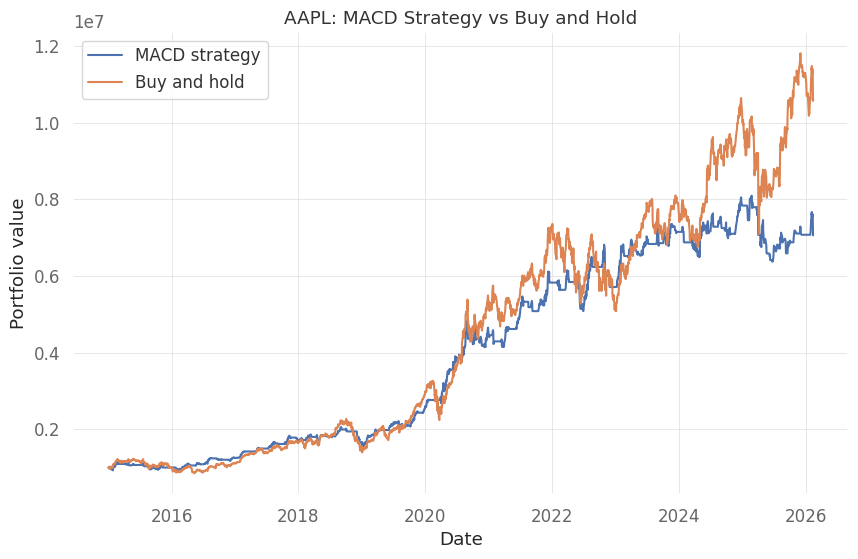

In [ ]:
# 1) Import your backtest engine (edit the module name to match your file)
from backtest_function import run_backtest

# 2) Define your MACD strategy function (returns RAW position, no shifting here)
def macd_strategy(prices, data, params) -> pd.Series: # data is a dataframe with all the price data, params is a dictionary with strategy parameters
    # _ is used to ignore the histogram output from calculate_macd since we only need macd and signal for our strategy
    macd, signal, _ = calculate_macd(prices)
        
    # long-only: 1 when MACD > signal else 0
    return (macd > signal).astype(float) # returns a series of Ts and Fs (converted to 1.0, 0.0), where 1 indicates a long position (MACD above signal) and 0 indicates no position (MACD below signal)

# 3) Run the backtest
res = run_backtest(
    ticker="AAPL",
    start="2015-01-01",
    strategy_fn=macd_strategy,
    strategy_params={"fast_span": 12, "slow_span": 26, "signal_span": 9},
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005,
    shift_signals_by=1,   # avoids look-ahead bias
    auto_adjust=True
)

# 4) Print results
for k, v in res.results.items(): #.item is a method that returns a view object that displays a list of a dictionary's key-value tuple pairs. k= key, v=value
    print(k, v)

# 5) Plot equity curves
plt.figure()
plt.plot(res.equity_strategy, label="MACD strategy")
plt.plot(res.equity_buyhold, label="Buy and hold")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()

#### **Reporting on graph**    

The orange line (buy and hold) grows faster in strong bull markets

The blue line (MACD) is smoother but **lags** badly when Apple trends strongly upward (MACD waits to be sure the move is real, not noise)

Key visual insights:

*1) 2019–2021 bull market*

- Buy and hold explodes upward

- MACD repeatedly exits and re-enters

- This causes missed upside

*2)2022 market crash*

- Buy and hold falls hard

- MACD falls much less

*3) Post-2023 recovery*

- Buy and hold again dominates

- MACD stays cautious and under-participates

#### **COVID Period Analysis**

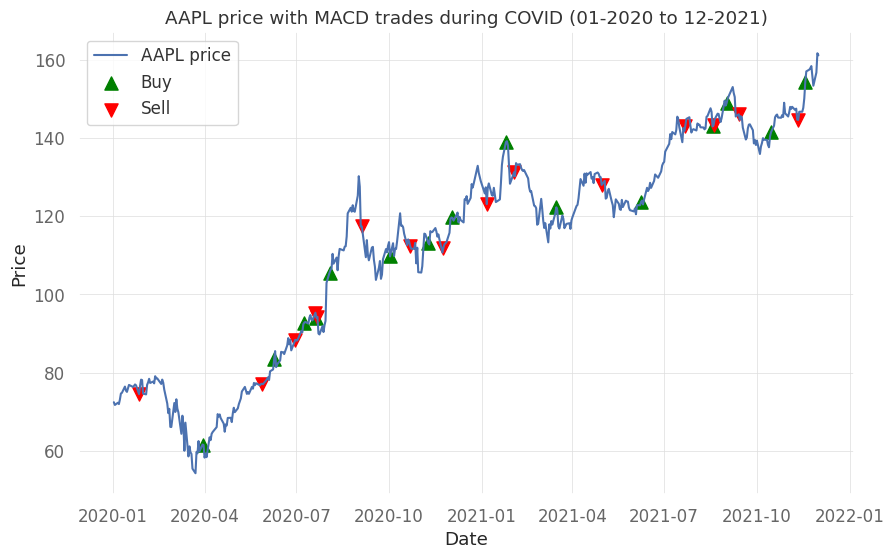

In [ ]:
# Analyze COVID period (2020-01-01 to 2021-12-01)
covid_start = "2020-01-01"
covid_end = "2021-12-01"

# Slice data for COVID period and match positions (in market 1, or not 0) to the price data during this period
px_covid = res.prices.loc[covid_start:covid_end] #loc slices prices by index labels.
pos_covid = res.position.reindex(px_covid.index).fillna(0).astype(int) # NaN -> 0, want integer positions (0 or 1), 

# Get entry and exit dates by detexting changes in position (from 0 to 1 is a buy, from 1 to 0 is a sell)
changes = pos_covid.diff().fillna(0) 
buy_dates = changes[changes == 1].index    #extract rows and date of position changes from 0 to 1, indicating a buy signal
sell_dates = changes[changes == -1].index  #extract rows and date of position changes from 1 to 0, indicating a sell signal

# Visualize
plt.figure()
plt.plot(px_covid.index, px_covid.values, label="AAPL price")
plt.scatter(buy_dates, px_covid.loc[buy_dates], marker="^", s=90, label="Buy", color='green') #s is marker size
plt.scatter(sell_dates, px_covid.loc[sell_dates], marker="v", s=90, label="Sell", color='red')
plt.title("AAPL price with MACD trades during COVID (01-2020 to 12-2021)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### **Final Quant (See File Named MACD Performance Report)**

In [ ]:

# Calculate returns
strategy_returns = res.equity_strategy.pct_change().dropna() #remove first value NaN and calculate percentage change to get returns
benchmark_returns = res.equity_buyhold.pct_change().dropna()

# Put both returns in the same dataframe and drop any rows with NaN values (due to different date ranges or missing data), axis = 1 means concatenate along columns (side by side)
df = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()

# Generate HTML report using qs-> quantstats
qs.reports.html(
    df.iloc[:, 0], #strategy returns, using iloc to select rows and columns by their numeric position, not by their names
    benchmark=df.iloc[:, 1],
    output="performancereportMACD.html",
    title="Strategy vs Benchmark"
)

print("Done: performancereportMACD.html")

#### **Key takeaway from report**

The MACD strategy does not beat buy and hold AAPL in raw returns, but it materially improves risk-adjusted performance and downside control.

1) **Lower returns, lower risk**
 - Buy and hold AAPL delivers higher cumulative return and CAGR (about 1004% and 24.25%) than the MACD strategy (about 655% and 20.05%). However, the strategy earns these returns with much lower volatility and shallower drawdowns

2) **Superior risk adjusted metrics**
 - The strategy has a higher Sharpe and Sortino, higher Omega, higher Calmar, and better Ulcer and Serenity indices. This means more return per unit of risk and pain, even though absolute returns are lower

3) **Limitation: Opportunity cost in strong bull markets**
 - The strategy underperforms badly in sustained momentum regimes (2017, 2019, 2021, 2023, 2024) because it exits too early and stays out of the market roughly 45% of the time 

4) **Limitation: Lag and whipsaw from backward looking signals -> unnecessary transaction costs**
 - MACD reacts after trends change. In sideways or slowly trending regimes this causes false exits and re-entries, lowering expected returns and profit ratio

